Lecture: AI I - Advanced 

Previous:
[**Chapter 4.1.2: Resnet**](../01_cv/02_resnet.ipynb)

---

# Chapter 4.2.1: Transformer with GPT2

- [Embedding](#embeddings-turning-words-into-numbers)
- [Tokenization](#tokenization-words-arent-the-unit)

This excursion takes you inside the architecture that powers modern language models: the Transformer. You'll learn how raw text becomes numbers, how the model "reads" and understands relationships between words, and how different Transformer variants are designed for different tasks. We finish with a hands-on GPT-2 example that covers everything from embedding words to generating text with fine-grained control over the output.

## Embeddings: Turning Words Into Numbers

Neural networks work with numbers. They can't process the word "cat" directly—they need a numerical representation. But how do you turn language into math in a way that preserves meaning?

A naive approach would be one-hot encoding: assign each word in your vocabulary a unique index and represent it as a vector of zeros with a single 1 at that index. The word "cat" in a vocabulary of 50,000 words becomes a vector of 50,000 dimensions with exactly one non-zero entry. This works technically, but it's catastrophic for learning: the vector for "cat" and the vector for "dog" are equally far apart as "cat" and "spaceship." The encoding carries zero semantic information.

### What Embeddings Actually Do

An embedding maps each word to a dense, low-dimensional vector (typically 128–1024 dimensions) where geometric relationships reflect semantic relationships. Words that appear in similar contexts end up close together in this space. "Cat" and "dog" cluster near each other. "Paris" and "London" are neighbors. "King" and "Queen" are related by roughly the same vector offset as "Man" and "Woman."

These vectors are not hand-crafted—they are learned during training. The embedding layer is just a large lookup table of trainable parameters. When the model sees a word, it retrieves the corresponding vector. During backpropagation, the gradients update these vectors so that words used in similar ways drift closer together and words used differently drift apart.
Think of it as the model building its own internal dictionary—not one that defines words with other words, but one that captures the role each word plays across millions of sentences.

![Embedding Space](./data/01_gpt2/space.png)

## Tokenization: Words Aren't the Unit

Modern language models don't actually work at the word level. They use subword tokenization—splitting text into smaller, reusable chunks. The word "unhappiness" might become `["un", "happiness"]` or even `["un", "hap", "pi", "ness"]` depending on the tokenizer. This solves the problem of rare or unseen words: even a word the model has never seen before can be composed from familiar subword pieces.

GPT-2 uses Byte Pair Encoding (BPE), which starts by splitting text into individual characters, then iteratively merges the most frequently co-occurring pair into a new token. Over many iterations, this builds a vocabulary of common subword units that can represent any text efficiently.

In [28]:
from transformers import GPT2Tokenizer, GPT2Model

model = GPT2Model.from_pretrained("gpt2")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

word = "cat"
input_ids = tokenizer(word).input_ids
print(f"Token IDs for the word {word}:", input_ids)

print("Token Embeddings size:", model.wte.weight.shape)
print("Positional Embeddings size:", model.wpe.weight.shape)

token_embedding = model.wte.weight[input_ids[0]]
pos_embedding = model.wpe.weight[0]
embedding = token_embedding + pos_embedding

print(f"Token embedding for '{word}':", token_embedding.shape, token_embedding.detach().numpy()[:5])
print("Positional embedding for position 0:", pos_embedding.shape, pos_embedding.detach().numpy()[:5])
print("Embedding:", embedding.shape, embedding.detach().numpy()[:5])

Token IDs for the word cat: [9246]
Token Embeddings size: torch.Size([50257, 768])
Positional Embeddings size: torch.Size([1024, 768])
Token embedding for 'cat': torch.Size([768]) [-0.01636109 -0.09340496  0.24245903  0.13976254  0.03876501]
Positional embedding for position 0: torch.Size([768]) [-0.01882072 -0.1974186   0.00402672  0.01134686  0.06382412]
Embedding: torch.Size([768]) [-0.03518181 -0.29082358  0.24648575  0.1511094   0.10258913]


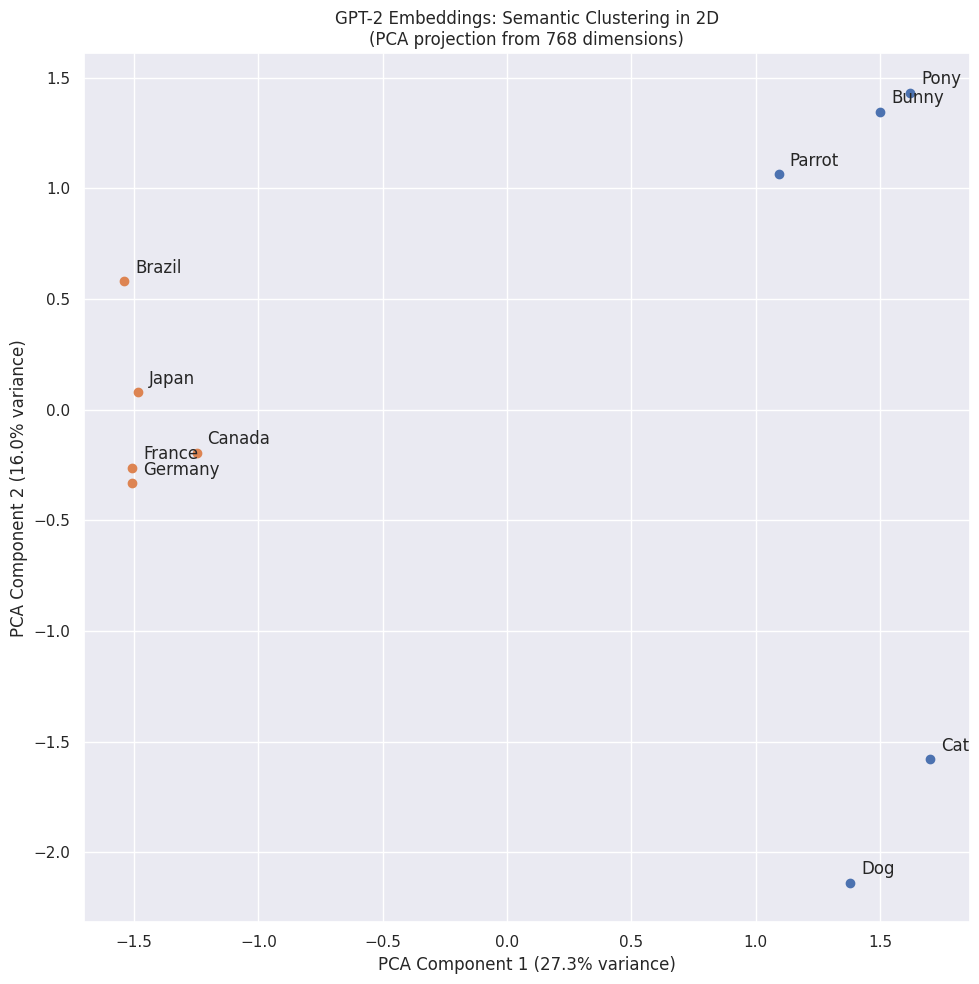

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

word_groups = {
    "animals": ["Cat", "Dog", "Parrot", "Pony", "Bunny"],
    "Countries": ["France", "Germany", "Japan", "Brazil", "Canada"],
}

embeddings = []
for word_list in word_groups.values():
    for word in word_list:
        input_ids = tokenizer(word).input_ids
        embedding = model.wte.weight[input_ids[0]]
        embeddings.append(embedding.detach().numpy())

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(embeddings_2d[:5, 0], embeddings_2d[:5, 1])
ax.scatter(embeddings_2d[5:, 0], embeddings_2d[5:, 1])

for i, word_list in enumerate(word_groups.values()):
    for j, word in enumerate(word_list):
        k = j + i * 5
        ax.annotate(word, (embeddings_2d[k, 0], embeddings_2d[k, 1]),
                textcoords="offset points", xytext=(8, 6))
        
ax.set_xlabel(f"PCA Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
ax.set_ylabel(f"PCA Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
ax.set_title("GPT-2 Embeddings: Semantic Clustering in 2D\n(PCA projection from 768 dimensions)")
fig.tight_layout()

**What to look for**: Words from the same semantic group cluster together—even though the model was never explicitly told "these words are related." This structure emerges purely from training on text.

---

Lecture: AI I - Advanced 

Next: [**Chapter 4.2.2: Data Structures**](../02_python/02_data_structures.ipynb)